# Salary Predictions Based on Job Descriptions
***

# Part 1 - DEFINE

### ---- 1 Define the problem ----

This is a salary prediction problem.

The training set contains jobs where both job descriptions and salaries are available. The test set contains jobs where only job descriptions are available.

The objective is to learn from the information provided in the job description to predict the salary.

In [1]:
#import libraries

#computing libs
import pandas as pd
import numpy as np
import scipy as sp

#viz libs
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#ml libs
import sklearn as sk
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

#other libs
import warnings
warnings.filterwarnings('ignore')

#info
__author__ = "Hieu Nguyen"
__email__ = "hieu.t.nguyen.aug25@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
#load the data into a Pandas dataframe
train_features = pd.read_csv("data/train_features.csv")
train_target = pd.read_csv("data/train_salaries.csv")
test_features = pd.read_csv("data/test_features.csv")

#### Examine the data

In [3]:
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [4]:
train_target.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [5]:
test_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


#### Further examination with .info()

In [6]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [7]:
train_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [8]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


<a id = '3'></a>
### ---- 3 Clean the data ----

Data Cleaning Performed:
- Found no duplicates
- Found no missing or NaN
- Dropped 5 rows where salary is zero  in the train set

In [9]:
#count the number of duplicated rows
print('test_features',test_features.duplicated().sum())
print('train_target',train_target.duplicated().sum())
print('train_features',train_features.duplicated().sum())

test_features 0
train_target 0
train_features 0


In [10]:
#if jobId is unique, there will zero duplicates
print('test_features',test_features['jobId'].duplicated().sum())
print('train_target',train_target['jobId'].duplicated().sum())
print('train_features',train_features['jobId'].duplicated().sum())

test_features 0
train_target 0
train_features 0


In [11]:
#confirming that jobId is a unique identifier between train_features and train_target df
train_features['jobId'].eq(train_target['jobId']).sum() == 1000000

True

In [12]:
#merge the train_target and train_features df by jobId
train = train_features.merge(train_target, on = 'jobId')

In [13]:
train.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [14]:
#merging successful
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [15]:
#count the total of NaN in any of the features in the train df
train.isna().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

In [16]:
#count the total of NaN in any of the features in the test df
test_features.isna().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

#### Looking for outliers salaries in the train df using the IQR rule

In [17]:
IQR = train['salary'].quantile(0.75) - train['salary'].quantile(0.25)
lower_whisker = train['salary'].quantile(0.25) - 1.5*IQR
upper_whisker = train['salary'].quantile(0.75) + 1.5*IQR

In [18]:
train[train.salary < lower_whisker].head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


Salary equals to zero does not make sense. This is likely incorrectly recorded.

In [19]:
train[train.salary > upper_whisker].head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
266,JOB1362684407953,COMP30,CEO,MASTERS,BIOLOGY,OIL,23,60,223
362,JOB1362684408049,COMP38,CTO,MASTERS,NONE,HEALTH,24,3,223
560,JOB1362684408247,COMP53,CEO,MASTERS,BIOLOGY,WEB,22,7,248
670,JOB1362684408357,COMP26,CEO,MASTERS,MATH,AUTO,23,9,240
719,JOB1362684408406,COMP54,VICE_PRESIDENT,DOCTORAL,BIOLOGY,OIL,21,14,225


In [20]:
#calculate the mean salary of these upper outliers by jobType
df1 = train[train.salary > upper_whisker].groupby(['jobType'])['salary'].mean().reset_index(name='Mean Salary')
#count the number of upper outliers by jobType
df2 = train[train.salary > upper_whisker].groupby(['jobType'])['salary'].count().reset_index(name='Count')
df1.join(df2.set_index('jobType'), on='jobType').sort_values(by='Count', ascending=False)

,jobType,Mean Salary,Count
0,CEO,235.938953,3227
1,CFO,233.816845,1496
2,CTO,233.889113,1488
6,VICE_PRESIDENT,232.325041,603
4,MANAGER,231.566820,217
5,SENIOR,229.196970,66
3,JUNIOR,227.800000,20


Many of these upper outliers are executives and senior level staffs. This is to be expected in salary data. The most suspicious group are those who held Junior roles.

#### Look for upper outliers in salary who held Junior roles

In [21]:
train[(train.salary > upper_whisker) & (train.jobType == 'JUNIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
189582,JOB1362684597269,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221
214606,JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
427593,JOB1362684835280,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3,221


These upper outliers who held Junior roles are all located in the Finance and Oil industry. Many of them also held terminal degrees in Business or Engineering. This is also to be expected.

#### Data cleaning decision: 
Do not drop any of the upper outliers. Drop rows where salary is zero

In [22]:
train_cleaned = train[train.salary > 0]

In [23]:
cat_features = ['companyId', 'jobType', 'degree', 'major', 'industry']
num_features = ['yearsExperience', 'milesFromMetropolis']

In [24]:
#encoding category features
for cat_feature in cat_features:
    train_cleaned[cat_feature] = train_cleaned[cat_feature].astype('category')

In [25]:
train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  999995 non-null object
companyId              999995 non-null category
jobType                999995 non-null category
degree                 999995 non-null category
major                  999995 non-null category
industry               999995 non-null category
yearsExperience        999995 non-null int64
milesFromMetropolis    999995 non-null int64
salary                 999995 non-null int64
dtypes: category(5), int64(3), object(1)
memory usage: 42.9+ MB


### ---- 4 Explore the data (EDA) ----

In [26]:
#create visualize_features function
def visualize_features(df,col):
    plt.figure(figsize = (18,8))
    if df[col].dtype == 'int64':
        #if column is numeric, plot a boxplot and the relationship between this feature and salary
        plt.subplot(121)
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.ylabel('Salaries')
        plt.fill_between(range(len(std.index)), mean.values - std.values, mean.values + std.values, alpha = 0.1)
        plt.subplot(122)
        sns.boxplot(train[col])
    else:
        #if column is categorical, plot a boxplot of salary grouped by the category's values
        mean = df.groupby(col)['salary'].mean()
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace=True)
        sns.boxplot(x = col, y = 'salary', data = df)
    plt.ylabel('Salaries')
    plt.show()

#### Visualize the features

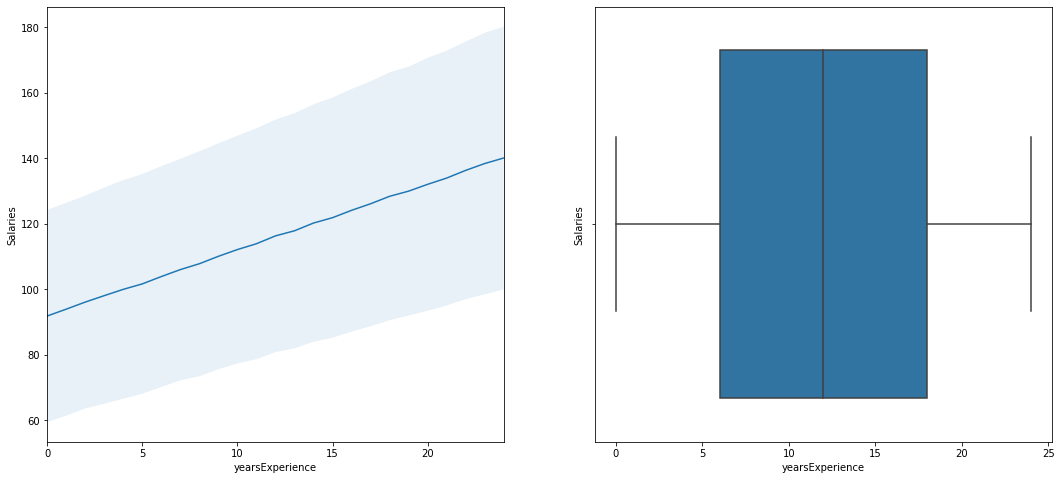

In [27]:
visualize_features(train_cleaned,'yearsExperience')

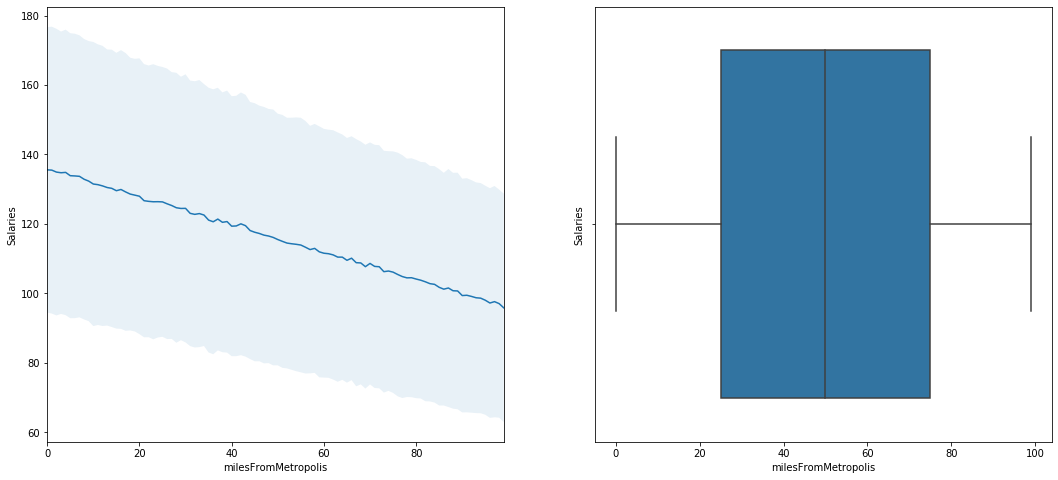

In [28]:
visualize_features(train_cleaned, 'milesFromMetropolis')

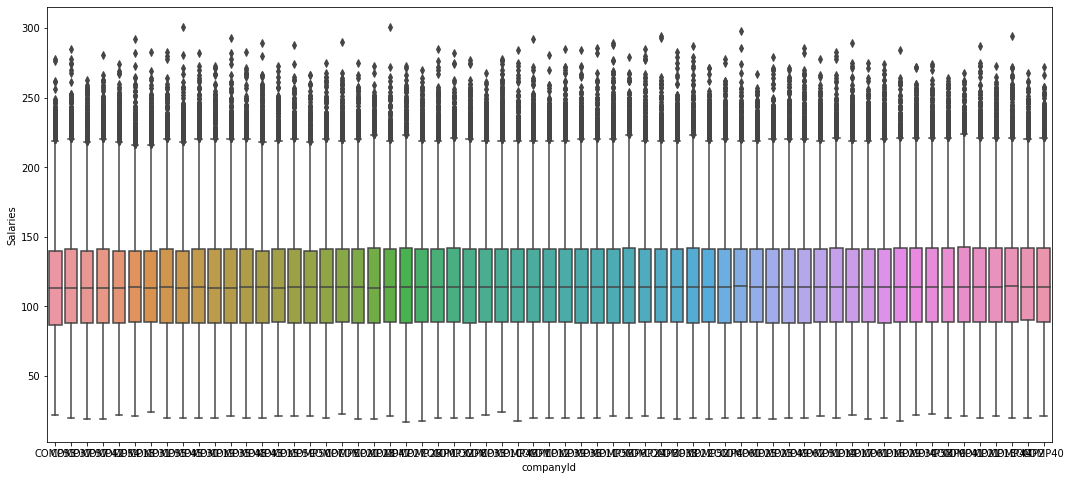

In [29]:
visualize_features(train_cleaned, 'companyId')

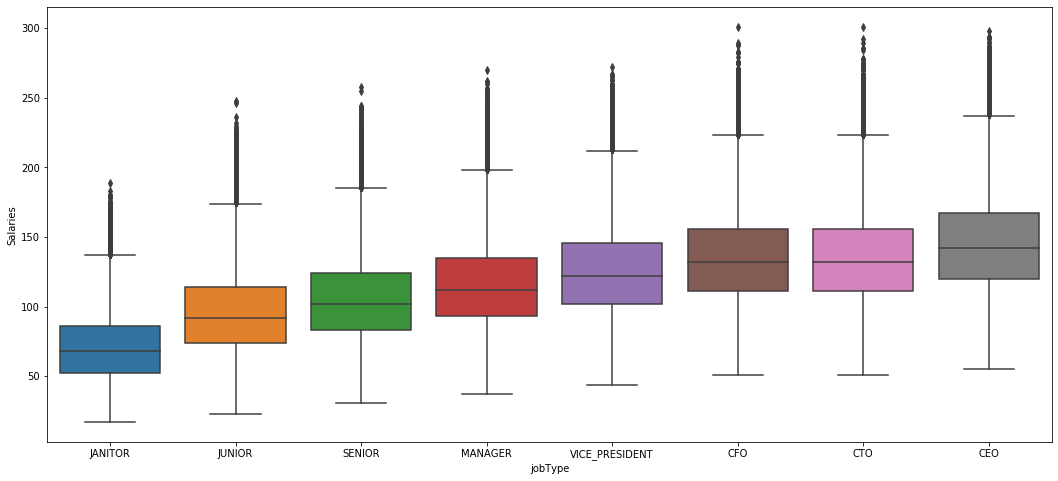

In [30]:
visualize_features(train_cleaned, 'jobType')

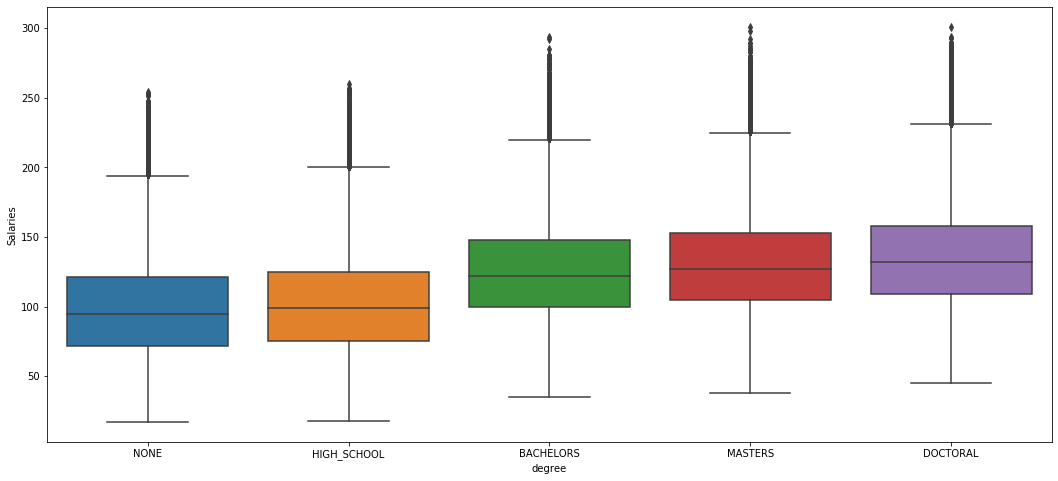

In [31]:
visualize_features(train_cleaned, 'degree')

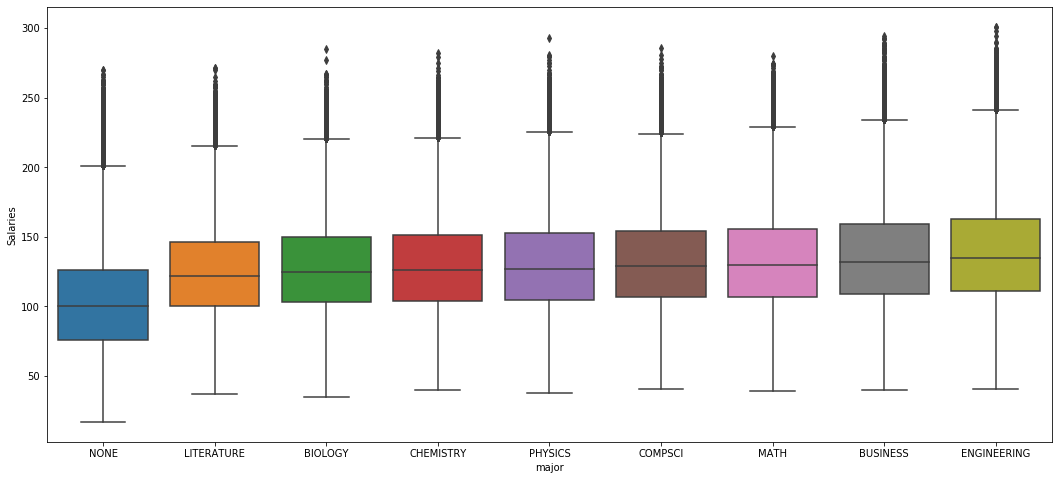

In [32]:
visualize_features(train_cleaned, 'major')

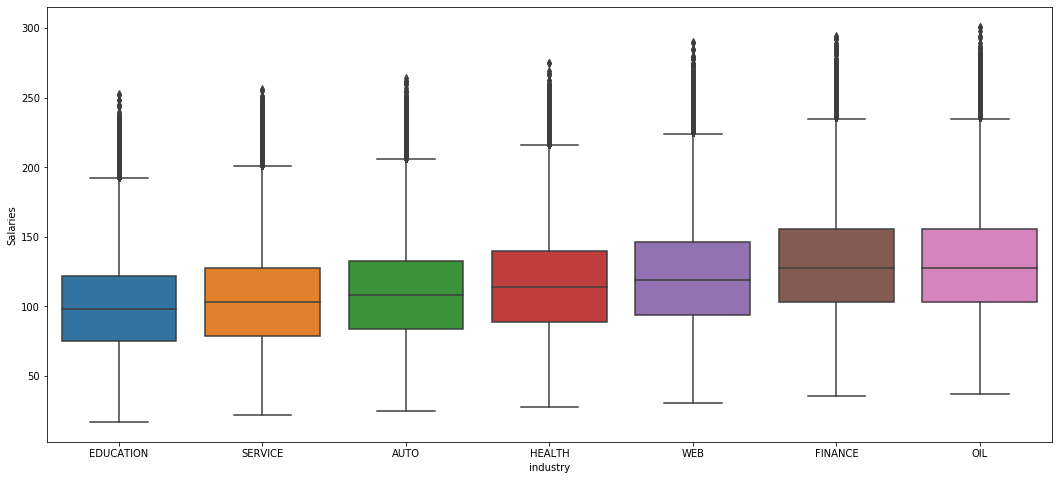

In [33]:
visualize_features(train_cleaned, 'industry')

#### Visualize the target variable

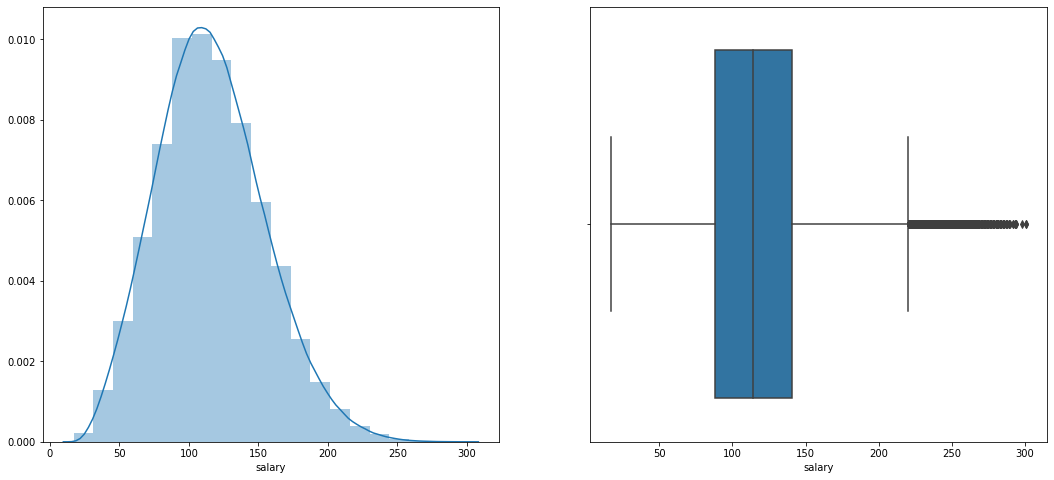

In [34]:
plt.figure(figsize = (18,8))
plt.subplot(121)
sns.distplot(train_cleaned.salary, bins = 20)
plt.subplot(122)
sns.boxplot(train_cleaned.salary)
plt.show()

In [35]:
train_cleaned['salary'].describe()

count    999995.000000
mean        116.062398
std          38.717163
min          17.000000
25%          88.000000
50%         114.000000
75%         141.000000
max         301.000000
Name: salary, dtype: float64

In [36]:
sp.stats.skew(train_cleaned.salary)

0.3465267592829531

#### The raw salary is positively skewed but the skewness is very minor. 

**Statistics Note:** When a variable to predict is skewed, the performance of models with a normality assumption such as Linear Regression might be negatively affected. However, since the magnitude of the skewness is less than 0.5, this distribution is approximately symmetric.

#### Visualize correlation between features and target variables

In [37]:
# Encode categorical variables with their group mean
def encode_label(df, col):
    cat_dict ={}
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = df[df[col] == cat]['salary'].mean()   
    df[col] = df[col].map(cat_dict)

In [38]:
train_cleaned_encoded = train_cleaned.copy()
for col in train_cleaned_encoded.columns:
    if train_cleaned_encoded[col].dtype.name == "category":
        encode_label(train_cleaned_encoded, col)

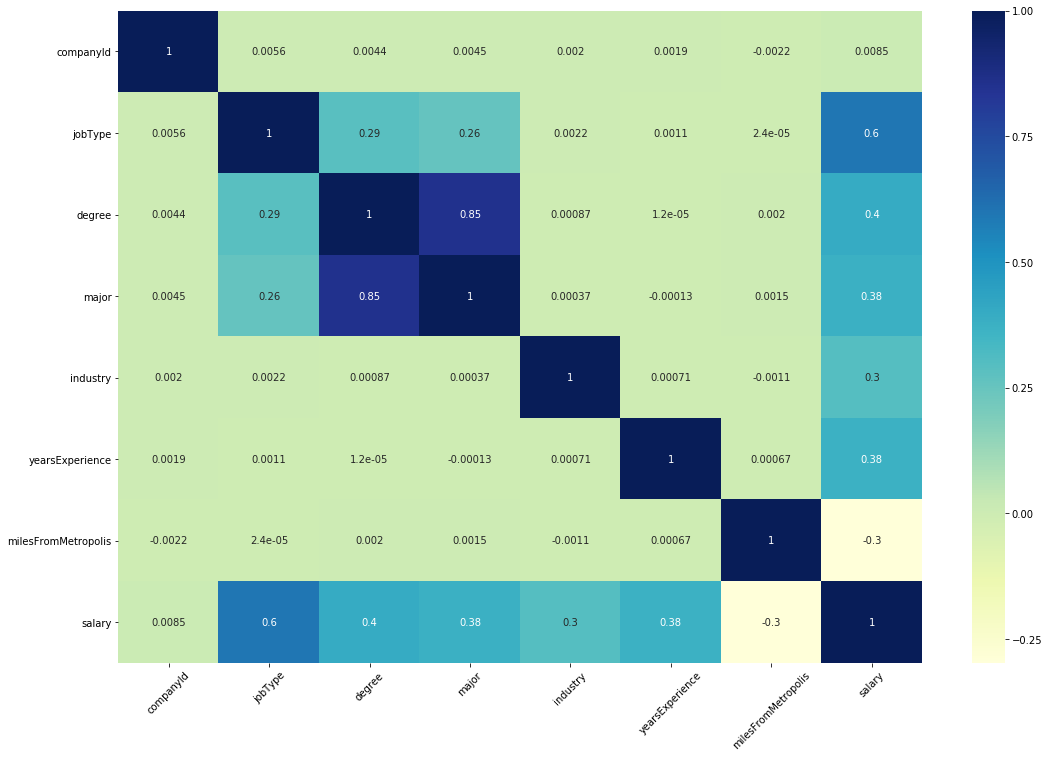

In [39]:
fig = plt.figure(figsize=(18, 12))
sns.heatmap(train_cleaned_encoded[cat_features + num_features + ['salary']].corr(), cmap='YlGnBu', annot=True)
plt.xticks(rotation=45)
plt.show()

### ---- 5 Establish a baseline ----

Since salary is a numerical and continuous variable. The metric used here is Mean squared error (MSE) measured during 5-fold cross-validation.

In this baseline model, we will use the average mean salary for each industry as the predicted salary.

This was already accomplished by the encode_label function.

In [40]:
train_cleaned_encoded.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,115.345049,135.458547,130.505647,133.322042,115.735540,10,83,130
1,JOB1362684407688,115.756548,145.311425,101.921085,102.583864,121.645362,3,73,101
2,JOB1362684407689,116.224249,125.368630,135.490979,130.372436,115.735540,10,38,137
3,JOB1362684407690,116.199380,115.368518,135.490979,129.072085,109.435222,8,17,142
4,JOB1362684407691,115.888501,125.368630,125.454663,130.372436,130.747659,8,16,163


In [41]:
print('Baseline Model MSE on entire train set:', '{:.4f}'.format(mean_squared_error(train_cleaned_encoded.salary, train_cleaned_encoded.industry)))

Baseline Model MSE on entire train set: 1367.1230


### ---- 6 Hypothesize solution ----

Three models will be trained:
- Linear Regression
- Random Forest Regression
- Gradient Boosting Regression

New features to be engineered:
- **Dummy** features for categorical features: jobType, degree, major, and industry
- **imputedAge**, which assumes about each individual:
    + the individual's age is equals to years of education plus years of experience plus 7
    + the individual starts his/her formal education when he/she turns 7
    + no unemployment during his/her career
    + Highschool = 12 yrs
    + Bachelor = 16 yrs
    + Master's = 18 yrs
    + Doctoral = 25 yrs
    + For degree = None cases, the individual's imputed age will be 7 plus years of experience plus assumed 11 yrs
- **longTenure**, a dummy feature which equals to 1 if years of experience is greater than or equals to 10 yrs, and zero otherwise
- **advancedDegree**, a dummy feature which equals to 1 if degree is either Master's or Doctoral, and zero otherwise
- **executives**, a dummy feature which equals to 1 if jobType is CFO, CTO, or CEO, and zero otherwise
- **seniorManagement**, a dummy feature which equals to 1 if jobType is Senior, Manager, or Vice President, and zero otherwise
- **executivesWithAdvDegree**, a dummy feature which equals to 1 if the individual is an executive with an advanced degree, and zero otherwise
- **city**, a dummy feature which equals to 1 if the distance from metropolis is less than 10 miles
- **suburb**, a dummy feature which equals to 1 if the distance from metropolis is between 10 miles and 50 miles
- **rural**, a dummy feature which equals to 1 if the distance from metropolis is greater than 50 miles

## Part 3 - DEVELOP

### ---- 7 Engineer features  ----

In [42]:
#cleaned train set before feature engineering
train_cleaned.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [43]:
#removing companyId as a categorical feature, see EDA for detail
cat_features = ['jobType', 'degree', 'major', 'industry']
num_features = ['yearsExperience', 'milesFromMetropolis']

#separate target
train_cleaned_target = train_cleaned.salary

#create train features df
train_cleaned_features = train_cleaned[num_features + cat_features]

In [44]:
#create imputedAge feature 
train_cleaned_features['imputedAge'] = 7 + train_cleaned_features['yearsExperience']
train_cleaned_features.loc[train_cleaned_features['degree'] == 'NONE', 'imputedAge'] += 11
train_cleaned_features.loc[train_cleaned_features['degree'] == 'HIGH_SCHOOL', 'imputedAge'] += 12
train_cleaned_features.loc[train_cleaned_features['degree'] == 'BACHELORS', 'imputedAge'] += 16
train_cleaned_features.loc[train_cleaned_features['degree'] == 'MASTERS', 'imputedAge'] += 18
train_cleaned_features.loc[train_cleaned_features['degree'] == 'DOCTORAL', 'imputedAge'] += 25

#produce dummy variables for categorical features
cat_df = pd.get_dummies(train_cleaned_features[cat_features])
num_features = ['yearsExperience', 'milesFromMetropolis', 'imputedAge']
train_cleaned_features = pd.concat([train_cleaned_features[num_features], cat_df], axis=1)

#create longTenure feature
train_cleaned_features['longTenure'] = train_cleaned_features['yearsExperience'].apply(lambda x: 1 if x >= 10 else 0)

#create advancedDegree feature
train_cleaned_features['advancedDegree'] = 0
train_cleaned_features.loc[train_cleaned_features['degree_MASTERS'] == 1, 'advancedDegree'] = 1
train_cleaned_features.loc[train_cleaned_features['degree_DOCTORAL'] == 1, 'advancedDegree'] = 1

#create executives feature
train_cleaned_features['executives'] = 0
train_cleaned_features.loc[train_cleaned_features['jobType_CFO'] == 1, 'executives'] = 1
train_cleaned_features.loc[train_cleaned_features['jobType_CTO'] == 1, 'executives'] = 1
train_cleaned_features.loc[train_cleaned_features['jobType_CEO'] == 1, 'executives'] = 1

#create seniorManagement feature
train_cleaned_features['seniorManagement'] = 0
train_cleaned_features.loc[train_cleaned_features['jobType_SENIOR'] == 1, 'seniorManagement'] = 1
train_cleaned_features.loc[train_cleaned_features['jobType_MANAGER'] == 1, 'seniorManagement'] = 1
train_cleaned_features.loc[train_cleaned_features['jobType_VICE_PRESIDENT'] == 1, 'seniorManagement'] = 1

#create executivesWithAdvDegree feature
train_cleaned_features['executivesWithAdvDegree'] = 0
train_cleaned_features.loc[(train_cleaned_features['executives'] == 1) 
                            & (train_cleaned_features['advancedDegree'] == 1), 'executivesWithAdvDegree'] = 1

#create city feature
train_cleaned_features['city'] = train_cleaned_features['milesFromMetropolis'].apply(lambda x: 1 if x <= 10 else 0)

#create suburb feature
train_cleaned_features['suburb'] = train_cleaned_features['milesFromMetropolis'].apply(lambda x: 1 if (x > 10) and (x <= 50) else 0)

#create rural feature
train_cleaned_features['rural'] = train_cleaned_features['milesFromMetropolis'].apply(lambda x: 1 if x > 50 else 0)

In [45]:
#cleaned train features set after feature engineering
train_cleaned_features.head()

,yearsExperience,milesFromMetropolis,imputedAge,jobType_JANITOR,jobType_JUNIOR,jobType_SENIOR,jobType_MANAGER,jobType_VICE_PRESIDENT,jobType_CFO,jobType_CTO,...,industry_FINANCE,industry_OIL,longTenure,advancedDegree,executives,seniorManagement,executivesWithAdvDegree,city,suburb,rural
0,10,83,35,0,0,0,0,0,1,0,...,0,0,1,1,1,0,1,0,0,1
1,3,73,22,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,10,38,42,0,0,0,0,1,0,0,...,0,0,1,1,0,1,0,0,1,0
3,8,17,40,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0
4,8,16,31,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0


In [46]:
train_cleaned_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 40 columns):
yearsExperience            999995 non-null int64
milesFromMetropolis        999995 non-null int64
imputedAge                 999995 non-null int64
jobType_JANITOR            999995 non-null uint8
jobType_JUNIOR             999995 non-null uint8
jobType_SENIOR             999995 non-null uint8
jobType_MANAGER            999995 non-null uint8
jobType_VICE_PRESIDENT     999995 non-null uint8
jobType_CFO                999995 non-null uint8
jobType_CTO                999995 non-null uint8
jobType_CEO                999995 non-null uint8
degree_NONE                999995 non-null uint8
degree_HIGH_SCHOOL         999995 non-null uint8
degree_BACHELORS           999995 non-null uint8
degree_MASTERS             999995 non-null uint8
degree_DOCTORAL            999995 non-null uint8
major_NONE                 999995 non-null uint8
major_LITERATURE           999995 non-null uint8
major_B

### ---- 8 Create models ----

In [47]:
#initialize models
lr = LinearRegression()
rf = RandomForestRegressor()
gbm = GradientBoostingRegressor()

#containers
models = []
mean_mse = {}
cv_std = {}

### Tune models' hyperparameters

#### Tune hyperparameters for Random Forest Regressor

1 depth
The OOB Score is: 0.1113328620369437
 
2 depth
The OOB Score is: 0.2737664126715794
 
3 depth
The OOB Score is: 0.38773532641504904
 
4 depth
The OOB Score is: 0.45344545515321044
 
5 depth
The OOB Score is: 0.498497832356007
 
10 depth
The OOB Score is: 0.6166688681400851
 
20 depth
The OOB Score is: 0.6103687601999528
 


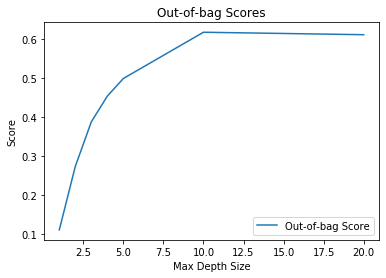

In [51]:
oob_scores  =  []
max_depth_size  = [1, 2, 3, 4, 5, 10, 20]

for depth in max_depth_size:
    model = RandomForestRegressor(max_depth=depth, oob_score=True, n_jobs=-1, random_state=44)
    model.fit(train_cleaned_features, train_cleaned_target)
    print(depth, 'depth')
    oob = model.oob_score_
    print('The OOB Score is: ' + str(model.oob_score_))
    oob_scores.append(oob)
    print (" ")

plt.plot(max_depth_size, oob_scores, label='Out-of-bag Score')
plt.xlabel('Max Depth Size')
plt.ylabel('Score')
plt.title('Out-of-bag Scores')
plt.legend(loc="lower right")
plt.show()

1 trees
The OOB Score is: -5.486567750281481
 
2 trees
The OOB Score is: -3.2595535878544917
 
3 trees
The OOB Score is: -1.8450997897569956
 
4 trees
The OOB Score is: -0.9435440221136313
 
5 trees
The OOB Score is: -0.36947597548423494
 
15 trees
The OOB Score is: 0.6591149131117711
 
20 trees
The OOB Score is: 0.678699574983406
 
25 trees
The OOB Score is: 0.6853908393130376
 
40 trees
The OOB Score is: 0.6936266016606256
 
50 trees
The OOB Score is: 0.6962557438859045
 


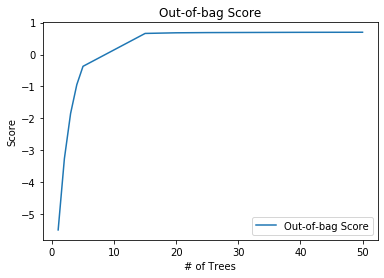

In [52]:
oob_scores = []
n_estimator_options = [1, 2, 3, 4, 5, 15, 20, 25, 40, 50]

for trees in n_estimator_options:
    model = RandomForestRegressor(n_estimators = trees, oob_score=True, n_jobs=-1, random_state=44)
    model.fit(train_cleaned_features, train_cleaned_target)
    print(trees, 'trees')
    oob = model.oob_score_
    print('The OOB Score is: ' + str(model.oob_score_))
    oob_scores.append(oob)
    print (" ")
    
plt.plot(n_estimator_options, oob_scores, label='Out-of-bag Score')
plt.xlabel('# of Trees')
plt.ylabel('Score')
plt.title('Out-of-bag Score')
plt.legend(loc="lower right")
plt.show()

1 min samples
The OOB Score is: 0.5488779430980624
 
2 min samples
The OOB Score is: 0.5862637677266365
 
3 min samples
The OOB Score is: 0.6051526495683867
 
4 min samples
The OOB Score is: 0.6164541063113667
 
5 min samples
The OOB Score is: 0.6236377555577788
 
6 min samples
The OOB Score is: 0.6287226400260215
 
7 min samples
The OOB Score is: 0.6326771004022125
 
8 min samples
The OOB Score is: 0.6354982884117468
 
9 min samples
The OOB Score is: 0.6377958512247832
 
10 min samples
The OOB Score is: 0.639742773422624
 
20 min samples
The OOB Score is: 0.6480969525026067
 


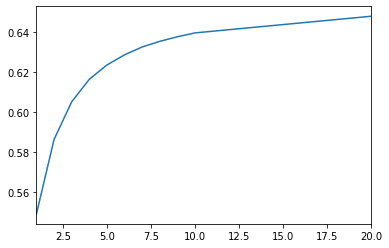

In [55]:
oob_scores = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(min_samples_leaf=min_samples, oob_score=True, n_jobs=-1, random_state=44)
    model.fit(train_cleaned_features, train_cleaned_target)
    print(min_samples, "min samples")
    oob = model.oob_score_
    print('The OOB Score is: ' + str(model.oob_score_))
    oob_scores.append(oob)
    print (" ")
    
pd.Series(oob_scores, min_samples_leaf_options).plot()
plt.show()

In [57]:
from sklearn.model_selection import GridSearchCV
param_grid = {"max_depth": [8,9,10,11],
              "min_samples_leaf" : [20,25,30],
              "n_estimators": [15,20,25]}

model = RandomForestRegressor()
gs_cv = GridSearchCV(model, param_grid = param_grid, cv = 3, verbose=10, n_jobs=-1).fit(train_cleaned_features, train_cleaned_target)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 39.1min finished


In [58]:
#select best model
rf_tuned = gs_cv.best_estimator_
rf_tuned

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=30, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=25,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

#### Tune hyperparameters for Gradient Boost

In [ ]:
results = []

for depth in [2,3,4,5,10]:
    gbrt = GradientBoostingRegressor(max_depth = depth)
    gbrt.fit(train_cleaned_features, train_cleaned_target)
    results.append({'max_depth': depth,
                   'train_error': mean_squared_error(train_cleaned_target, gbrt.predict(train_cleaned_features))})

max_depth_lr = pd.DataFrame(results).set_index('max_depth').sort_index()
max_depth_lr.plot(title="Max_Depth Learning Curve")
plt.show()

In [ ]:
results = []

for rate in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
    gbrt = GradientBoostingRegressor(learning_rate = rate)
    gbrt.fit(train_cleaned_features, train_cleaned_target)
    results.append({'learning_rate': rate,
            n         'train_error': mean_squared_error(train_cleaned_target, gbrt.predict(train_cleaned_features)),})

learning_rate_lr = pd.DataFrame(results).set_index('learning_rate').sort_index()
learning_rate_lr.plot(title = 'Learning Rate Learning Curve')
plt.show()

In [ ]:
model = GradientBoostingRegressor()
param_grid = {'max_depth': [2,3,5], 'learning_rate': [0.1,0.15,0.2,0.25]}
gs_cv = GridSearchCV(model, param_grid = param_grid, cv = 3, n_jobs = -1).fit(train_cleaned_features, train_cleaned_target)

#select best model
gbm_tuned = gs_cv.best_estimator_
gbm_tuned

### ---- 9 Test models ----

In [48]:
rf_tuned = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=30, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=25,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

gbm_tuned = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=150, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

models.extend([lr, rf_tuned, gbm_tuned])
for model in models:
    neg_mse = cross_val_score(model, train_cleaned_features, train_cleaned_target, 
                              cv=5, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])


Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Average MSE:
 384.41834607438847
Standard deviation during CV:
 1.778554398988393

Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=30, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=25,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
Average MSE:
 402.65306266782005
Standard deviation during CV:
 2.043657109146556

Model:
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_i

### ---- 10 Select best model  ----

In [49]:
best_model = min(mean_mse, key = mean_mse.get)
print('Best model:', best_model)
print('Best model Cross-validation MSE:', '{:.4f}'.format(mean_mse[best_model]))

Best model: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
Best model Cross-validation MSE: 357.3012


## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [ ]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data